# [CausalLift](https://medium.com/@Minyus86/causallift-python-package-for-uplift-modeling-in-real-world-business-e60264812a26)

This library uses the two-model approach. Sample dataset [here](https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html). Github [here](https://github.com/Minyus/causallift/).

Outcome does not necessarily need to be bool for two-model approach, just for this library, but we could easily use linear regression instead.

In [126]:
# 1.0 Import some tools we'll need
import pandas
import numpy as np
import warnings
from sklearn.model_selection import train_test_split

#!pip3 install matplotlib
import matplotlib

# !pip3 install xgboost
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# 2.0 Install & Import the Library
# !pip3 install causallift
from causallift import CausalLift

In [143]:
# 3.0 Get some data
cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep='\s+', header = None, names = cols)
treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep='\s+', header = None, names = cols)
lalonde_df = pd.concat([control_df, treated_df], ignore_index=True)
lalonde_df['u74'] = np.where(lalonde_df['re74'] == 0, 1.0, 0.0)
lalonde_df['u75'] = np.where(lalonde_df['re75'] == 0, 1.0, 0.0)
df = lalonde_df[['nodegr', 'black', 'hisp', 'age', 'educ', 'married', 'u74', 'u75', 'treat', 're78']].copy()
df.rename(columns={'treat':'Treatment', 're78':'Outcome'}, inplace=True)
df['Outcome'] = np.where(df['Outcome'] > 0, 1.0, 0.0)
clean_data=df
clean_data.head()

,nodegr,black,hisp,age,educ,married,u74,u75,Treatment,Outcome
0,1.0,1.0,0.0,23.0,10.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,26.0,12.0,0.0,1.0,1.0,0.0,1.0
2,1.0,1.0,0.0,22.0,9.0,0.0,1.0,1.0,0.0,0.0
3,1.0,1.0,0.0,18.0,9.0,0.0,1.0,1.0,0.0,1.0
4,1.0,1.0,0.0,45.0,11.0,0.0,1.0,1.0,0.0,1.0


In [144]:
clean_data.describe()

,nodegr,black,hisp,age,educ,married,u74,u75,Treatment,Outcome
count,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,0.782022,0.833708,0.08764,25.370787,10.195506,0.168539,0.732584,0.649438,0.415730,0.692135
std,0.413337,0.372762,0.28309,7.100282,1.792119,0.374766,0.443109,0.477683,0.493402,0.462130
min,0.000000,0.000000,0.00000,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.00000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.00000,24.000000,10.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,0.00000,28.000000,11.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.00000,55.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [145]:
clean_data.corr()

,nodegr,black,hisp,age,educ,married,u74,u75,Treatment,Outcome
nodegr,1.000000,0.041948,0.086638,-0.112838,-0.635575,-0.038554,0.049934,0.079798,-0.151012,-0.045548
black,0.041948,1.000000,-0.693969,0.087171,0.045405,0.023731,0.030152,0.038685,0.021602,-0.167117
hisp,0.086638,-0.693969,1.000000,-0.090157,-0.144835,0.009064,-0.046158,0.011191,-0.084066,0.120627
age,-0.112838,0.087171,-0.090157,1.000000,0.022964,0.210072,0.102457,0.075597,0.052977,-0.010435
educ,-0.635575,0.045405,-0.144835,0.022964,1.000000,0.081613,-0.092843,-0.127603,0.070890,0.004852
married,-0.038554,0.023731,0.009064,0.210072,0.081613,1.000000,-0.080614,-0.096973,0.046531,0.027178
u74,0.049934,0.030152,-0.046158,0.102457,-0.092843,-0.080614,1.000000,0.726574,-0.046647,-0.061988
u75,0.079798,0.038685,0.011191,0.075597,-0.127603,-0.096973,0.726574,1.000000,-0.087400,-0.061491
Treatment,-0.151012,0.021602,-0.084066,0.052977,0.070890,0.046531,-0.046647,-0.087400,1.000000,0.118087
Outcome,-0.045548,-0.167117,0.120627,-0.010435,0.004852,0.027178,-0.061988,-0.061491,0.118087,1.000000


In [138]:
# 4.0 Split data into train and test
train_df, test_df = train_test_split(clean_data, test_size=0.2, random_state=0, stratify=clean_data['Treatment'])

[2019-11-10 10:29:45,383|causallift.context.flexible_context|INFO] Run pipeline (tags: ['011_bundle_train_and_test_data'], SequentialRunner, only_missing: False)
[2019-11-10 10:29:45,395|kedro.pipeline.node|INFO] Running node: bundle_train_and_test_data([args_raw,test_df,train_df]) -> [df_00]
[2019-11-10 10:29:45,398|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2019-11-10 10:29:45,399|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2019-11-10 10:29:45,402|causallift.context.flexible_context|INFO] Run pipeline (tags: ['121_prepare_args', '131_treatment_fractions_', '141_initialize_model'], SequentialRunner, only_missing: False)
[2019-11-10 10:29:45,416|kedro.pipeline.node|INFO] Running node: impute_cols_features([args_raw,df_00]) -> [args_intermediate]
[2019-11-10 10:29:45,417|kedro.runner.sequential_runner|INFO] Completed 1 out of 3 tasks
[2019-11-10 10:29:45,419|kedro.pipeline.node|INFO] Running node: treatment_fractions_([args_raw,

,nodegr,black,hisp,age,educ,married,u74,u75
coefficient,-0.528687,0.006952,-0.240273,0.018189,-0.017729,0.156942,-0.079416,-0.198944


[2019-11-10 10:29:46,701|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2019-11-10 10:29:46,702|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2019-11-10 10:29:46,704|causallift.context.flexible_context|INFO] Run pipeline (tags: ['221_estimate_propensity'], SequentialRunner, only_missing: False)
[2019-11-10 10:29:46,715|kedro.pipeline.node|INFO] Running node: estimate_propensity([args,df_00,propensity_model]) -> [df_01]
[2019-11-10 10:29:46,721|causallift.nodes.estimate_propensity|INFO] 
### Histogram of propensity score for train and test data:
[2019-11-10 10:29:46,748|causallift.nodes.estimate_propensity|INFO] [Warning] Could not show the histogram.
[2019-11-10 10:29:46,751|causallift.nodes.estimate_propensity|INFO] 
### Score Table for logistic regression to calculate propensity score:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,356,2,0.615169,0.612245,0.202703,0.304569,0.555678,0.41573,0.137640
test,89,2,0.573034,0.478261,0.297297,0.366667,0.533264,0.41573,0.258427


[2019-11-10 10:29:46,768|causallift.nodes.estimate_propensity|INFO] 
### Confusion Matrix for Train:


,Pred_0,Pred_1
True_0,189,19
True_1,118,30


[2019-11-10 10:29:46,772|causallift.nodes.estimate_propensity|INFO] 
### Confusion Matrix for Test:


,Pred_0,Pred_1
True_0,40,12
True_1,26,11


[2019-11-10 10:29:46,780|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2019-11-10 10:29:46,780|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2019-11-10 10:29:46,783|causallift.causal_lift|INFO] ### Treatment fraction in train dataset: 0.4157303370786517
[2019-11-10 10:29:46,784|causallift.causal_lift|INFO] ### Treatment fraction in test dataset: 0.4157303370786517


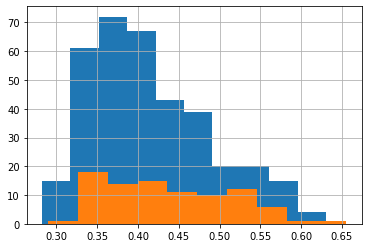

In [139]:
# 5.0 Feed in data, enable_ipw appends propensity scores using logistic regression 
# There should be at least three columns, Treatment (bool), Outcome (bool), and 1+ feature columns (named anything)
cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

In [140]:
# 6.0 Train 2 models independently and calculate CATE 
train_df, test_df = cl.estimate_cate_by_2_models()

[2019-11-10 10:29:46,956|causallift.context.flexible_context|INFO] Run pipeline (tags: ['311_fit', '312_bundle_2_models'], SequentialRunner, only_missing: False)
[2019-11-10 10:29:46,965|kedro.pipeline.node|INFO] Running node: model_for_treated_fit([args,df_01]) -> [treated__model_dict]
[2019-11-10 10:29:46,966|causallift.nodes.model_for_each|INFO] 

## Model for Treatment = 1.0
[2019-11-10 10:29:48,120|causallift.nodes.model_for_each|INFO] ### Best parameters of the model trained using samples with observational Treatment: 1.0 
 {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'verbose': 0}
[2019-11-10 10:29:48,129|causallift.nodes.model_for_each|INFO] 
### Feature 

,0,1,2,3,4,5,6,7
feature importance,0.08543,0.241736,0.07125,0.129926,0.09927,0.063142,0.107687,0.20156


[2019-11-10 10:29:48,147|causallift.nodes.model_for_each|INFO] 
### Outcome estimated by the model trained using samples with observational Treatment: 1.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,148,2,0.878378,0.880952,0.973684,0.925000,0.766254,0.770270,0.851351
test,37,2,0.594595,0.677419,0.807692,0.736842,0.449301,0.702703,0.837838


[2019-11-10 10:29:48,156|kedro.runner.sequential_runner|INFO] Completed 1 out of 3 tasks
[2019-11-10 10:29:48,158|kedro.pipeline.node|INFO] Running node: model_for_untreated_fit([args,df_01]) -> [untreated__model_dict]
[2019-11-10 10:29:48,158|causallift.nodes.model_for_each|INFO] 

## Model for Treatment = 0.0
[2019-11-10 10:29:49,187|causallift.nodes.model_for_each|INFO] ### Best parameters of the model trained using samples with observational Treatment: 0.0 
 {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'verbose': 0}
[2019-11-10 10:29:49,196|causallift.nodes.model_for_each|INFO] 
### Feature importances of the model trained using samples with observational Tre

,0,1,2,3,4,5,6,7
feature importance,0.159774,0.090003,0.050203,0.13739,0.076655,0.195488,0.102582,0.187904


[2019-11-10 10:29:49,217|causallift.nodes.model_for_each|INFO] 
### Outcome estimated by the model trained using samples with observational Treatment: 0.0


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,208,2,0.783654,0.771930,0.956522,0.854369,0.699689,0.663462,0.822115
test,52,2,0.557692,0.581395,0.833333,0.684932,0.507576,0.576923,0.826923


[2019-11-10 10:29:49,225|kedro.runner.sequential_runner|INFO] Completed 2 out of 3 tasks
[2019-11-10 10:29:49,229|kedro.pipeline.node|INFO] Running node: bundle_treated_and_untreated_models([treated__model_dict,untreated__model_dict]) -> [uplift_models_dict]
[2019-11-10 10:29:49,233|kedro.runner.sequential_runner|INFO] Completed 3 out of 3 tasks
[2019-11-10 10:29:49,234|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2019-11-10 10:29:49,237|causallift.context.flexible_context|INFO] Run pipeline (tags: ['321_predict_proba'], SequentialRunner, only_missing: False)
[2019-11-10 10:29:49,248|kedro.pipeline.node|INFO] Running node: model_for_treated_predict_proba([args,df_01,uplift_models_dict]) -> [treated__proba]
[2019-11-10 10:29:49,254|kedro.runner.sequential_runner|INFO] Completed 1 out of 2 tasks
[2019-11-10 10:29:49,258|kedro.pipeline.node|INFO] Running node: model_for_untreated_predict_proba([args,df_01,uplift_models_dict]) -> [untreated__proba]
[2019

In [141]:
# 7.0 Estimate uplift
estimated_effect_df = cl.estimate_recommendation_impact()
display(estimated_effect_df)

[2019-11-10 10:29:49,294|causallift.context.flexible_context|INFO] Run pipeline (tags: ['511_recommend_by_cate'], SequentialRunner, only_missing: False)
[2019-11-10 10:29:49,303|kedro.pipeline.node|INFO] Running node: recommend_by_cate([args,df_02,treatment_fractions]) -> [df_03]
[2019-11-10 10:29:49,324|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2019-11-10 10:29:49,324|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2019-11-10 10:29:49,333|causallift.context.flexible_context|INFO] Run pipeline (tags: ['521_simulate_recommendation'], SequentialRunner, only_missing: False)
[2019-11-10 10:29:49,350|kedro.pipeline.node|INFO] Running node: model_for_treated_simulate_recommendation([args,df_03,uplift_models_dict]) -> [treated__sim_eval_df]
[2019-11-10 10:29:49,372|causallift.nodes.model_for_each|INFO] 
### Simulated outcome of samples recommended to be treatment: 1.0 by the uplift model:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,148,2,0.682432,0.682432,1.0,0.811245,0.5,0.682432,1.0
test,37,2,0.594595,0.594595,1.0,0.745763,0.5,0.594595,1.0


[2019-11-10 10:29:49,388|kedro.runner.sequential_runner|INFO] Completed 1 out of 2 tasks
[2019-11-10 10:29:49,397|kedro.pipeline.node|INFO] Running node: model_for_untreated_simulate_recommendation([args,df_03,uplift_models_dict]) -> [untreated__sim_eval_df]
[2019-11-10 10:29:49,422|causallift.nodes.model_for_each|INFO] 
### Simulated outcome of samples recommended to be treatment: 0.0 by the uplift model:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,208,2,0.740385,0.738916,0.993377,0.847458,0.531776,0.725962,0.975962
test,52,2,0.634615,0.647059,0.970588,0.776471,0.485294,0.653846,0.980769


[2019-11-10 10:29:49,437|kedro.runner.sequential_runner|INFO] Completed 2 out of 2 tasks
[2019-11-10 10:29:49,438|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2019-11-10 10:29:49,442|causallift.context.flexible_context|INFO] Run pipeline (tags: ['531_estimate_effect'], SequentialRunner, only_missing: False)
[2019-11-10 10:29:49,452|kedro.pipeline.node|INFO] Running node: estimate_effect([treated__sim_eval_df,untreated__sim_eval_df]) -> [estimated_effect_df]
[2019-11-10 10:29:49,457|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2019-11-10 10:29:49,458|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2019-11-10 10:29:49,460|causallift.causal_lift|INFO] 
### Treated samples without and with uplift model:


,# samples chosen without uplift model,observed conversion rate without uplift model,# samples recommended by uplift model,predicted conversion rate using uplift model,predicted improvement rate
0,148,0.770270,148,1.0,1.298246
1,37,0.702703,37,1.0,1.423077


[2019-11-10 10:29:49,465|causallift.causal_lift|INFO] 
### Untreated samples without and with uplift model:


,# samples chosen without uplift model,observed conversion rate without uplift model,# samples recommended by uplift model,predicted conversion rate using uplift model,predicted improvement rate
0,208,0.663462,208,0.975962,1.471014
1,52,0.576923,52,0.980769,1.700000


,# samples,observed conversion rate without uplift model,predicted conversion rate using uplift model,predicted improvement rate
0,356,0.707865,0.985955,1.392857
1,89,0.629213,0.988764,1.571429


# [Pylift](https://tech.wayfair.com/data-science/2018/10/pylift-a-fast-python-package-for-uplift-modeling/)

This library uses the transformed outcome approach. Github [here](https://github.com/wayfair/pylift/)

In [153]:
#!pip3 install pylift

import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
from pylift import TransformedOutcome

# Specify your dataframe, treatment column, and outcome column.
up = TransformedOutcome(clean_data, col_treatment='Treatment', col_outcome='Outcome', stratify=df['Treatment'])

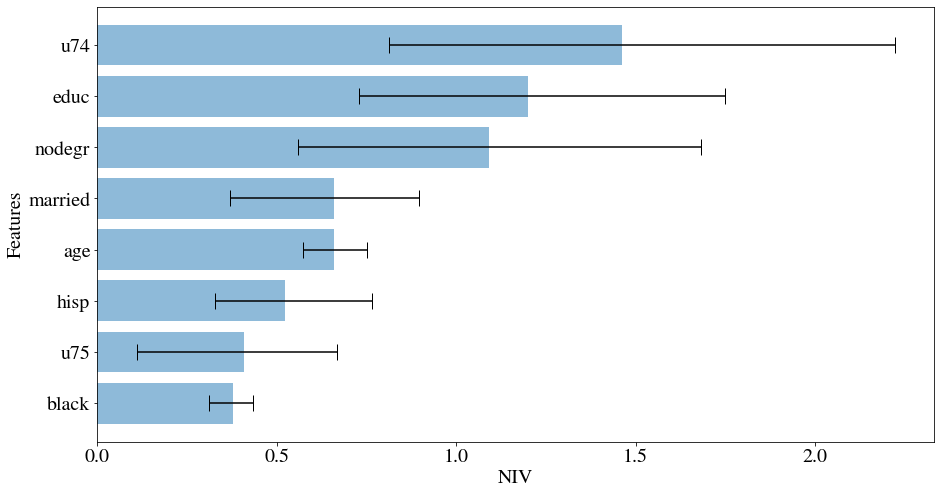

In [154]:
# This function randomly shuffles your training data set and calculates net information value.
up.NIV()

In [161]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);


[11:23:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 0 finished.
[11:23:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 1 finished.
[11:23:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 2 finished.
[11:23:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 3 finished.
[11:23:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 4 finished.


[2019-11-10 11:23:24,235|matplotlib.legend|WARNING] No handles with labels found to put in legend.
[2019-11-10 11:23:24,239|matplotlib.legend|WARNING] No handles with labels found to put in legend.
[2019-11-10 11:23:24,242|matplotlib.legend|WARNING] No handles with labels found to put in legend.
[2019-11-10 11:23:24,245|matplotlib.legend|WARNING] No handles with labels found to put in legend.
[2019-11-10 11:23:24,247|matplotlib.legend|WARNING] No handles with labels found to put in legend.


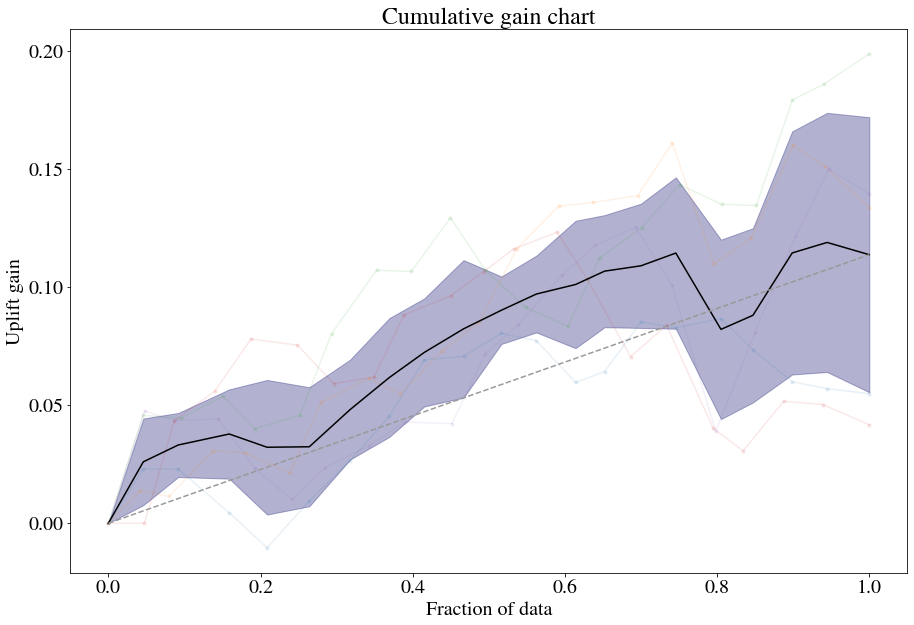

In [162]:
up.plot(show_shuffle_fits=True)


In [163]:
up.model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.334967421262261,
             gamma=5.358964059155116, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=8, min_child_weight=3, missing=None,
             n_estimators=86, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.3208609507276753, verbosity=1)